In [17]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [18]:
index = pd.date_range("2021-09-01", periods=2400, freq="1H")
df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index)
df

,a,b
2021-09-01 00:00:00,0,a
2021-09-01 01:00:00,1,b
2021-09-01 02:00:00,2,c
2021-09-01 03:00:00,3,a
2021-09-01 04:00:00,4,d
...,...,...
2021-12-09 19:00:00,2395,a
2021-12-09 20:00:00,2396,d
2021-12-09 21:00:00,2397,d
2021-12-09 22:00:00,2398,b


In [19]:
# Now we have a DataFrame with 2 columns and 2400 rows composed of 10 partitions 
# where each partition has 240 rows. 
# Each partition represents a piece of the data.
ddf = dd.from_pandas(df, npartitions=10)
ddf

,a,b
npartitions=10,,
2021-09-01 00:00:00,int64,object
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [20]:
# check the index values covered by each partition
ddf.divisions

(Timestamp('2021-09-01 00:00:00', freq='H'),
 Timestamp('2021-09-11 00:00:00', freq='H'),
 Timestamp('2021-09-21 00:00:00', freq='H'),
 Timestamp('2021-10-01 00:00:00', freq='H'),
 Timestamp('2021-10-11 00:00:00', freq='H'),
 Timestamp('2021-10-21 00:00:00', freq='H'),
 Timestamp('2021-10-31 00:00:00', freq='H'),
 Timestamp('2021-11-10 00:00:00', freq='H'),
 Timestamp('2021-11-20 00:00:00', freq='H'),
 Timestamp('2021-11-30 00:00:00', freq='H'),
 Timestamp('2021-12-09 23:00:00', freq='H'))

In [21]:
# access a particular partition
ddf.partitions[1]

,a,b
npartitions=1,,
2021-09-11,int64,object
2021-09-21,...,...


In [22]:
ddf.b

Dask Series Structure:
npartitions=10
2021-09-01 00:00:00    object
2021-09-11 00:00:00       ...
                        ...  
2021-11-30 00:00:00       ...
2021-12-09 23:00:00       ...
Name: b, dtype: object
Dask Name: getitem, 20 tasks

In [23]:
ddf["2021-10-01": "2021-10-09 5:00"]

,a,b
npartitions=1,,
2021-10-01 00:00:00.000000000,int64,object
2021-10-09 05:00:59.999999999,...,...


In [24]:
ddf["2021-10-01": "2021-10-09 5:00"].compute()

,a,b
2021-10-01 00:00:00,720,a
2021-10-01 01:00:00,721,b
2021-10-01 02:00:00,722,c
2021-10-01 03:00:00,723,a
2021-10-01 04:00:00,724,d
...,...,...
2021-10-09 01:00:00,913,b
2021-10-09 02:00:00,914,c
2021-10-09 03:00:00,915,a
2021-10-09 04:00:00,916,d


In [25]:
ddf.a.mean()

dd.Scalar<series-..., dtype=float64>

In [26]:
ddf.a.mean().compute()

1199.5

In [27]:
df.a.mean()

1199.5

In [28]:
ddf.b.unique().compute()

0    a
1    b
2    c
3    d
4    e
Name: b, dtype: object

In [29]:
df.b.unique()

array(['a', 'b', 'c', 'd', 'e'], dtype=object)

In [42]:
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum() - 100
result.compute()

2021-10-01 00:00:00       620
2021-10-01 01:00:00      1341
2021-10-01 02:00:00      2063
2021-10-01 03:00:00      2786
2021-10-01 04:00:00      3510
                        ...  
2021-10-09 01:00:00    158301
2021-10-09 02:00:00    159215
2021-10-09 03:00:00    160130
2021-10-09 04:00:00    161046
2021-10-09 05:00:00    161963
Freq: H, Name: a, Length: 198, dtype: int64

In [31]:
result.dask

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x13272dd90>
 0. from_pandas-0b850a81e4dfe2d272df4dc718065116
 1. loc-43bdf3e7bbcd4c2a7c873d4ac8559d74
 2. getitem-6a4bb79967064beb7a290c59b3d5d546
 3. series-cumsum-map-da525a8249311f7599dec13eb29dd073
 4. series-cumsum-take-last-055345035e0a892bfbbbfb440e79040a
 5. series-cumsum-3f86da579516ca1f705ab21690f09be3
 6. sub-7f3120b7cfe5605f104dca986bafb549

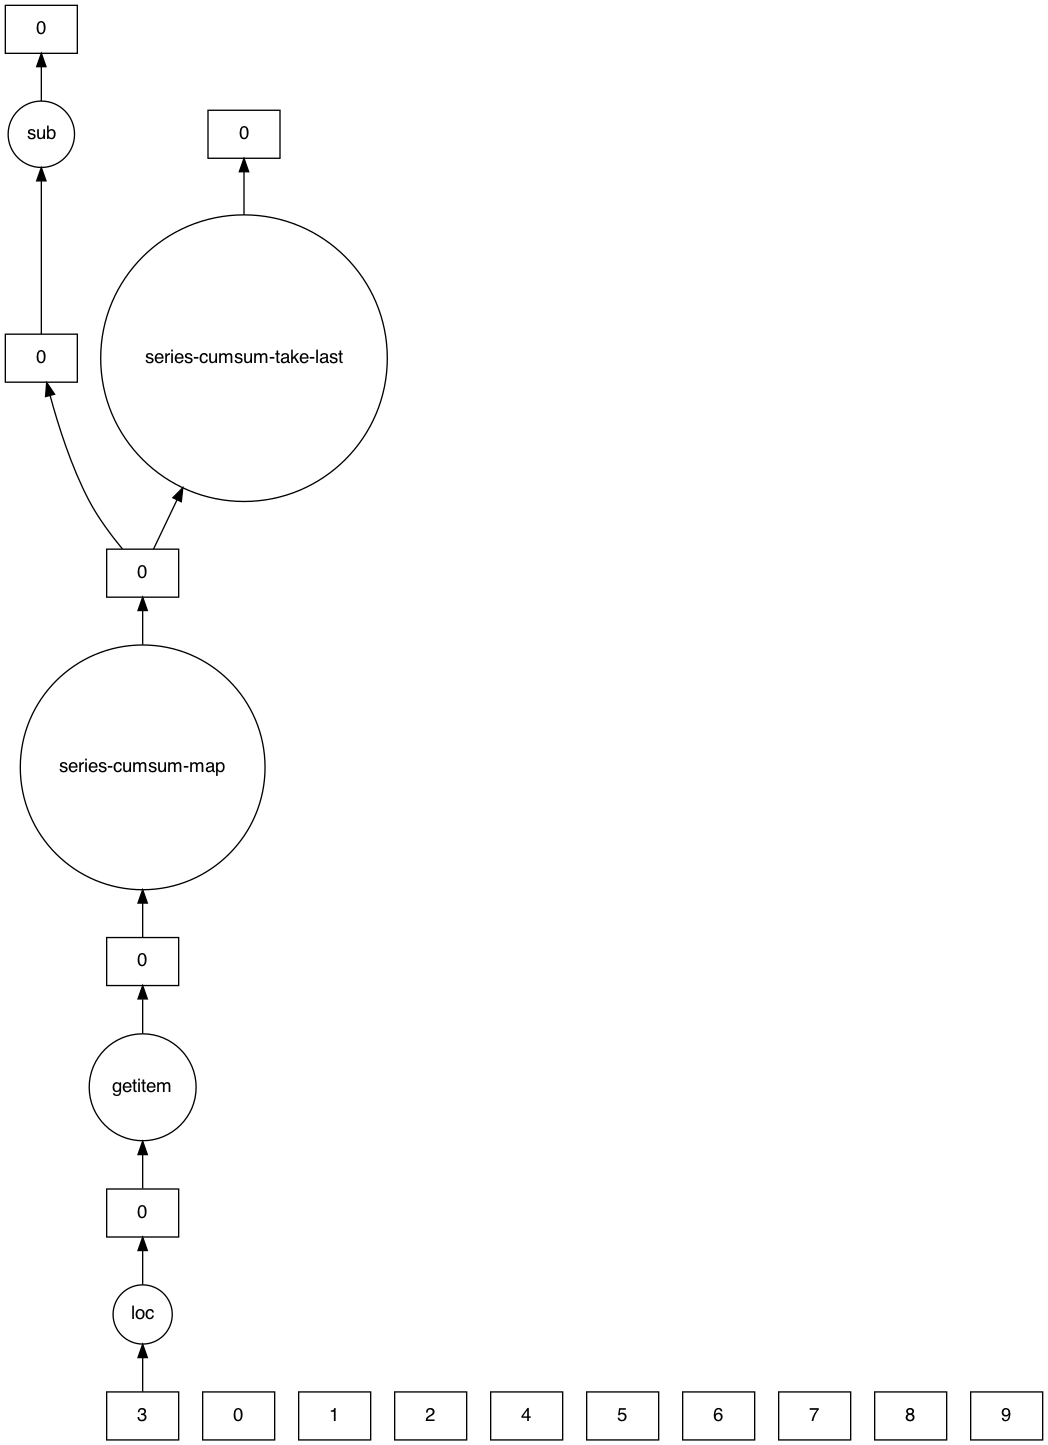

In [32]:
result.visualize()

In [41]:
import dask

@dask.delayed
def inc(x):
   return x + 1

@dask.delayed
def add(x, y):
   return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)    # no work has happened yet


In [39]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:56629/status,
Dashboard: http://127.0.0.1:56629/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56630,Workers: 4
Dashboard: http://127.0.0.1:56629/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56645,Total threads: 2
Dashboard: http://127.0.0.1:56646/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:56635,


In [40]:
client.dashboard_link

'http://127.0.0.1:56629/status'

In [43]:
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum() - 100
result.compute()

2021-10-01 00:00:00       620
2021-10-01 01:00:00      1341
2021-10-01 02:00:00      2063
2021-10-01 03:00:00      2786
2021-10-01 04:00:00      3510
                        ...  
2021-10-09 01:00:00    158301
2021-10-09 02:00:00    159215
2021-10-09 03:00:00    160130
2021-10-09 04:00:00    161046
2021-10-09 05:00:00    161963
Freq: H, Name: a, Length: 198, dtype: int64